# Building A Handwritten Digits Classifier

Image classification is difficult for machine learning (ML) models because:
1. Images are usually high dimensional which equates to a significant number of pixels/ features. E.g. a 128 x 128 image has 16384 features.
2. They have to be down sampled to lower resolution in grayscale form for faster processing, which results in lost data that adversely affects ML modeling.
3. Image features do not have an obvious linear/ non-linear relationship that can be learned using ML models. In grayscale, each pixel is simply represented as a brightness value ranging from 0 to 256.

Deep learning (DL) is a more effective alternative for image classification because of the DL models' ability to learn hierarchical representations. At a high level, an effective DL model learns intermediate representations at each layer in the model and uses them in the prediction process.

### Working With Image Data
We'll be using the load_digits() dataset from sklearn.datasets. This is a copy of the [handwritten digits dataset from UCI](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

In our dataset, each image is represented as a row of pixel values. We'll load the dataset, convert the pixels into a dataframe, separate the target field and visualize some images using ax.imshow().

**Import Libraries**

In [2]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

**Load Dataset**

In [3]:
data = load_digits(return_X_y=True, as_frame=True)
df = pd.DataFrame(data[0])
target = pd.Series(data[1])

df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


**Visualize Images**

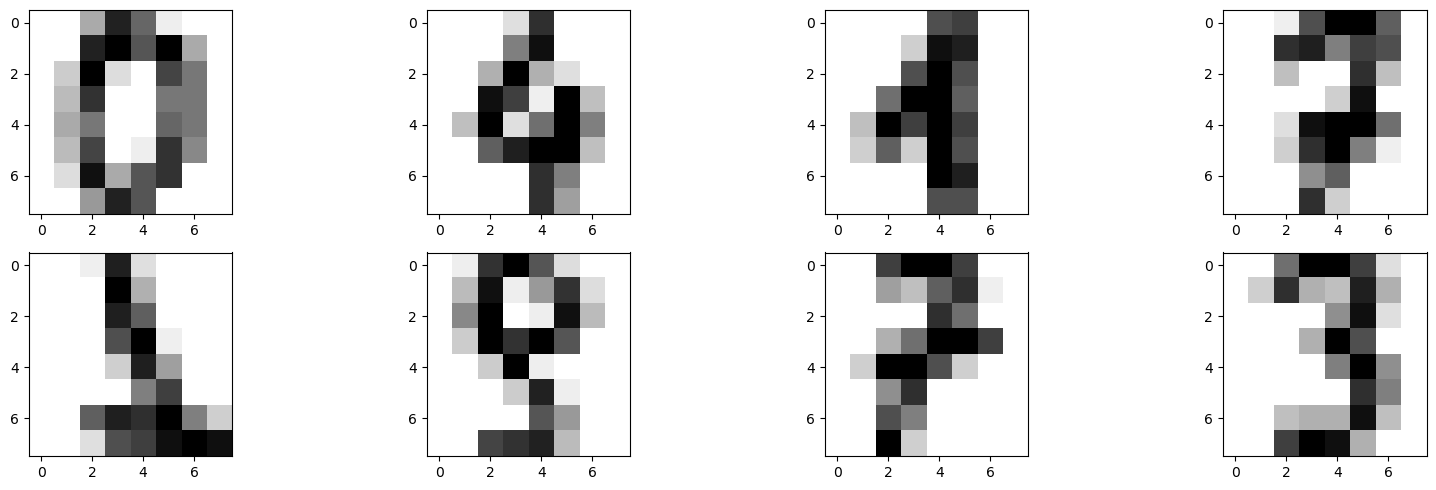

In [4]:
rel_rows = df.iloc[[0, 100, 200, 300, 1000, 1100, 1200, 1300], :]
rel_rows.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(2, 4, figsize=(17, 5))
for i, ax in enumerate(axs.flat):
    img = rel_rows.iloc[i, :].values.reshape(8, 8)
    ax.imshow(img, cmap='gray_r')

plt.tight_layout()
plt.show()

### K-Nearest Neighbors Model
While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors (KNN) algorithm make no such assumption. This allows them to capture nonlinearity in the data.

The KNN algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

**Develop Train & Test Sets**

In [5]:
np.random.seed(8)
shuffled_index = np.random.permutation(df.index)

# Shuffle the data using the random seed index
shuffled_data = df.loc[shuffled_index]
shuffled_labels = target.loc[shuffled_index]

mid_length = int(len(shuffled_data) / 2)

# X_train, X_test
train_features = shuffled_data.iloc[0:mid_length]
test_features = shuffled_data.iloc[mid_length:
                                   len(shuffled_data)]
# y_train, y_test
train_labels = shuffled_labels.iloc[0:mid_length]
test_labels = shuffled_labels.iloc[mid_length:
                                   len(shuffled_labels)]

**Train & Test Pipelines**

In [6]:
def train(model, X_train, y_train):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)

    return train_accuracy

def test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    return test_accuracy

def cross_validate(df, target, model):
    test_accuracies = list()
    train_accuracies = list()

    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(df):
        X_train = df.iloc[train_index].copy()
        X_test = df.iloc[test_index].copy()
        y_train = target.iloc[train_index].copy()
        y_test = target.iloc[test_index].copy()

        train_accuracies.append(train(model, X_train, y_train))
        test_accuracies.append(test(model, X_test, y_test))

    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)

    return avg_test_accuracy, avg_train_accuracy

In [7]:
test_accuracy_scores = list()
train_accuracy_scores = list()

k_values = range(1,11)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    test_accuracy, train_accuracy = cross_validate(df=df,
                                                   target=target,
                                                   model=knn)
    test_accuracy_scores.append(test_accuracy)
    train_accuracy_scores.append(train_accuracy)

../../compiler/lib/


**Plotting the K-Values & Accuracy Scores**

Test accuracy puts optimum k at 3.

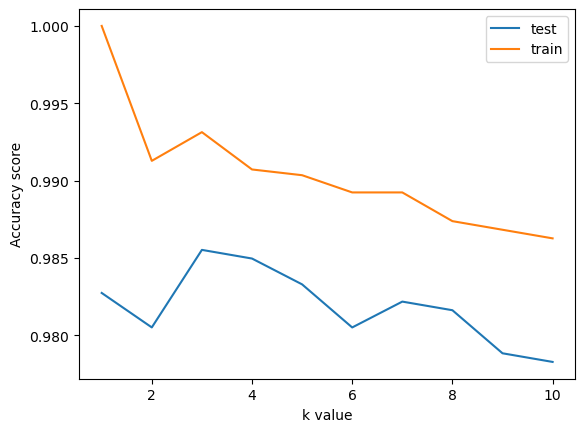

In [8]:
plt.plot(k_values, test_accuracy_scores)
plt.plot(k_values, train_accuracy_scores)
plt.legend(["test", "train"])
plt.xlabel("k value")
plt.ylabel("Accuracy score")
plt.show()

### Neural Network With One Hidden Layer

**Train & Test Modeling without Cross Validation**

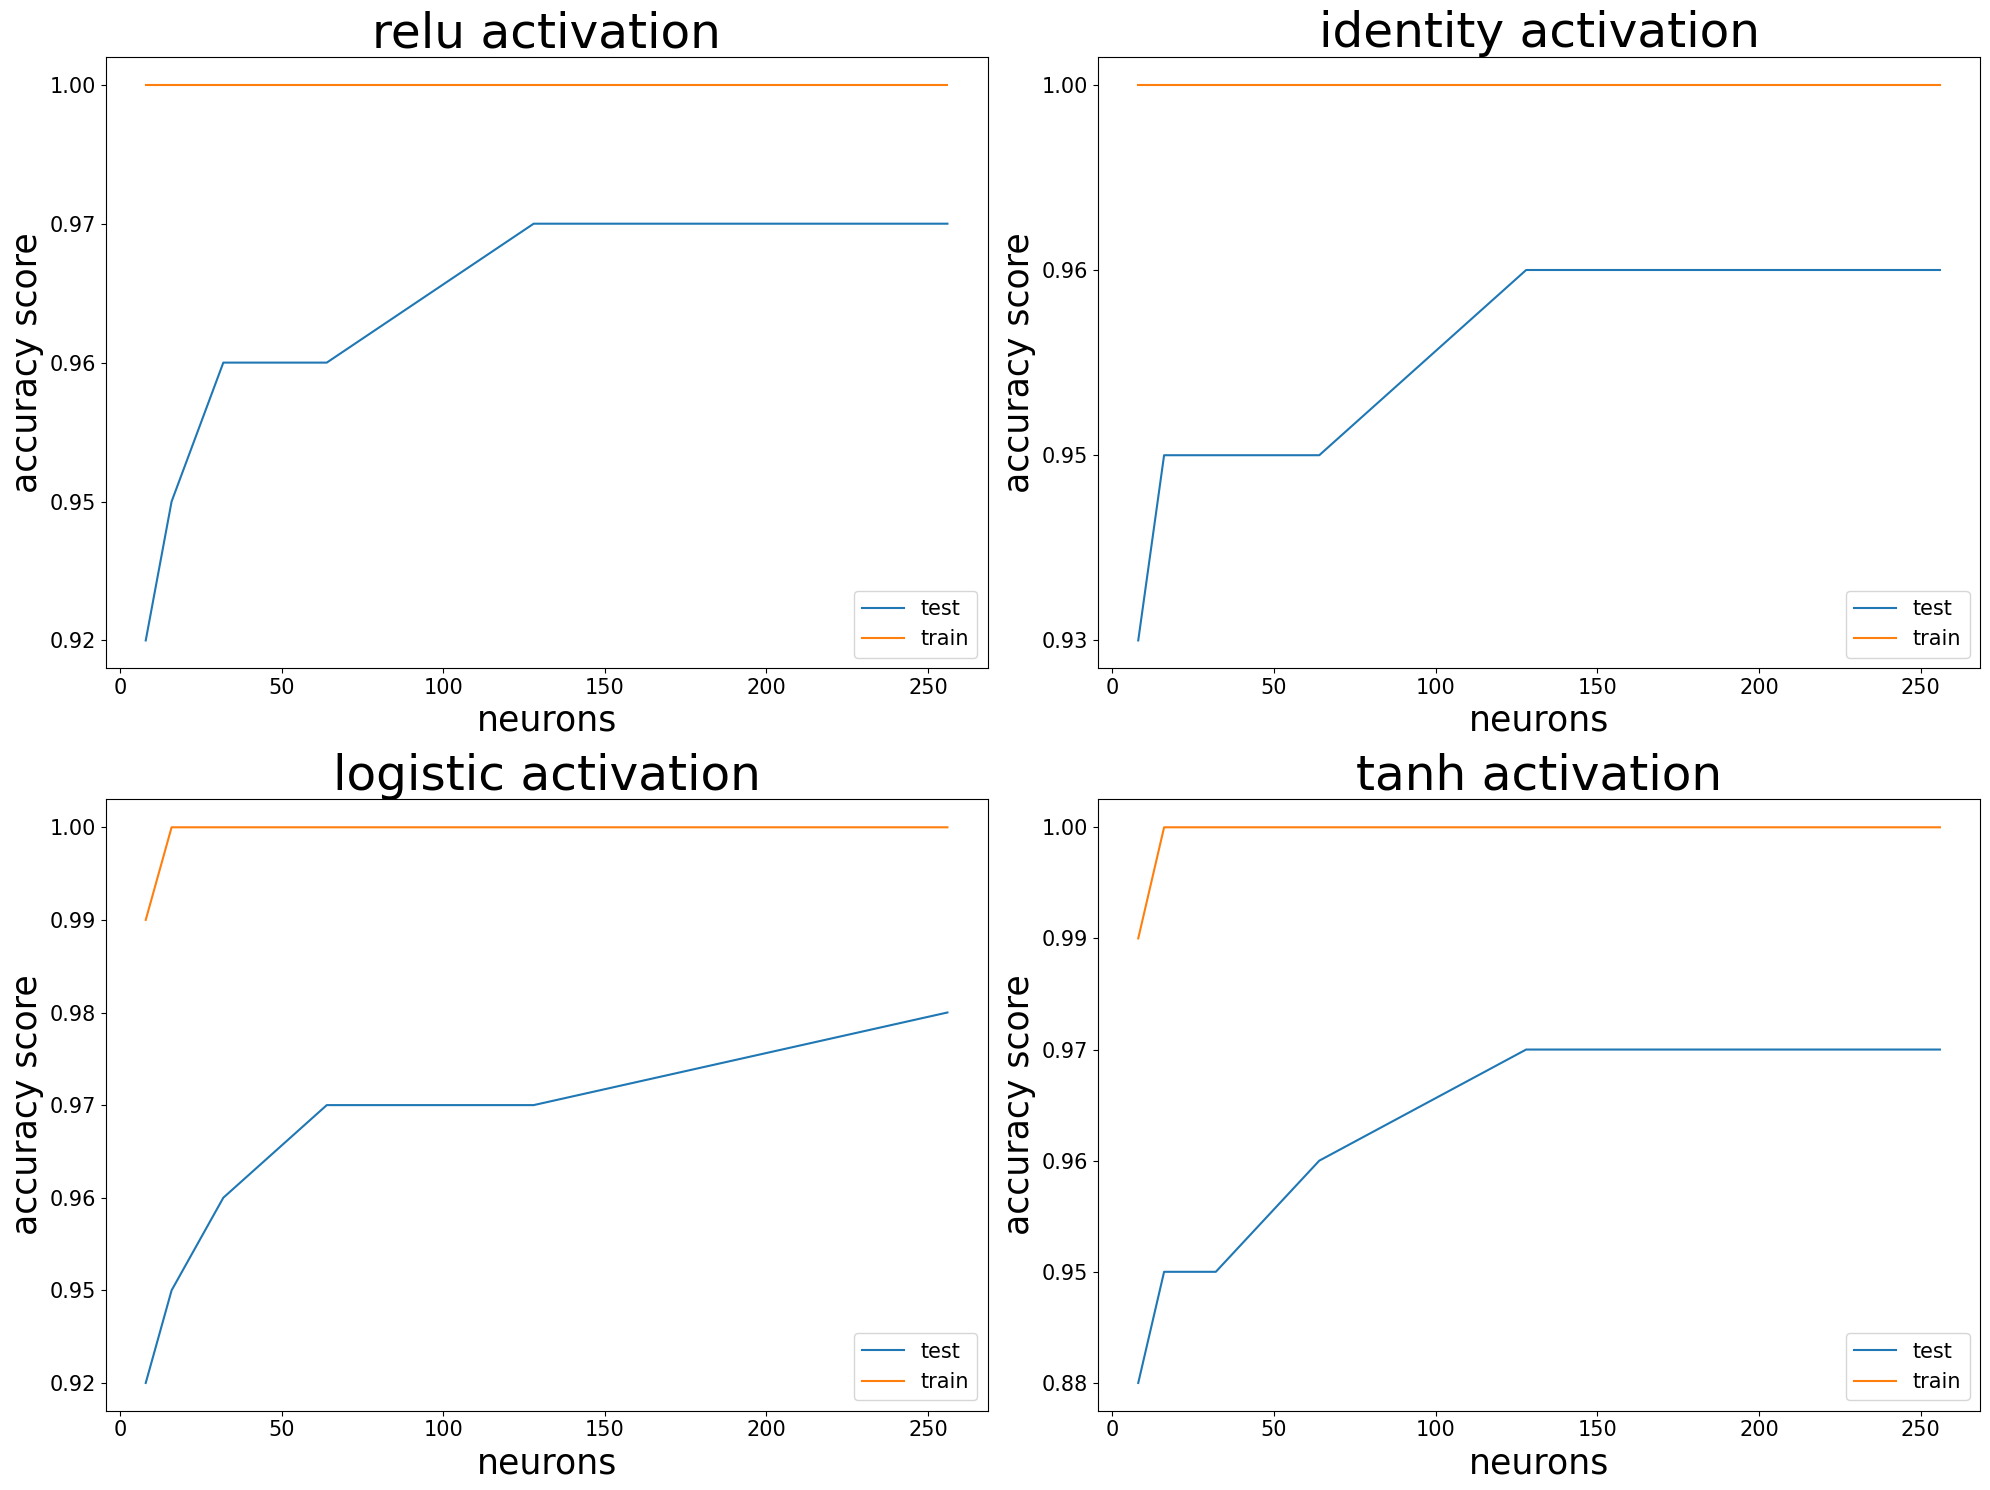

In [9]:
activations = ['relu', 'identity', 'logistic', 'tanh']
plt.figure(figsize=(20,15))
plot_num = list(range(1,5))


for act, num in zip(activations, plot_num):
    neurons = [8, 16, 32, 64, 128, 256]
    nn_train_accuracies = list()
    nn_test_accuracies = list()

    for i in neurons:
        mlp = MLPClassifier(hidden_layer_sizes=(i, ),
                            activation=act,
                            max_iter=1000)
        mlp.fit(train_features, train_labels)
        nn_train_accuracy = mlp.score(train_features, train_labels)
        nn_train_accuracies.append(f'{nn_train_accuracy:.2f}')

        nn_predictions = mlp.predict(test_features)
        nn_test_accuracy = accuracy_score(test_labels,
                                     nn_predictions)
        nn_test_accuracies.append(f'{nn_test_accuracy:.2f}')

    plt.subplot(2, 2, num)
    plt.plot(neurons, nn_test_accuracies)
    plt.plot(neurons, nn_train_accuracies)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(["test", "train"], fontsize=15)
    plt.xlabel("neurons", size=25)
    plt.ylabel("accuracy score", size=25)
    plt.title(f'{act} activation', size=35)

plt.tight_layout()
plt.show()

Things to Note:
* With every execution, the test accuracy for each activation changes.
* All activation flatten around 97% accuracy although logistic activation seems to be heading upward toward a 98% accuracy.
* ReLU & Logistic flatten around 128 neurons.

**Train & Test Modeling with Cross Validation**

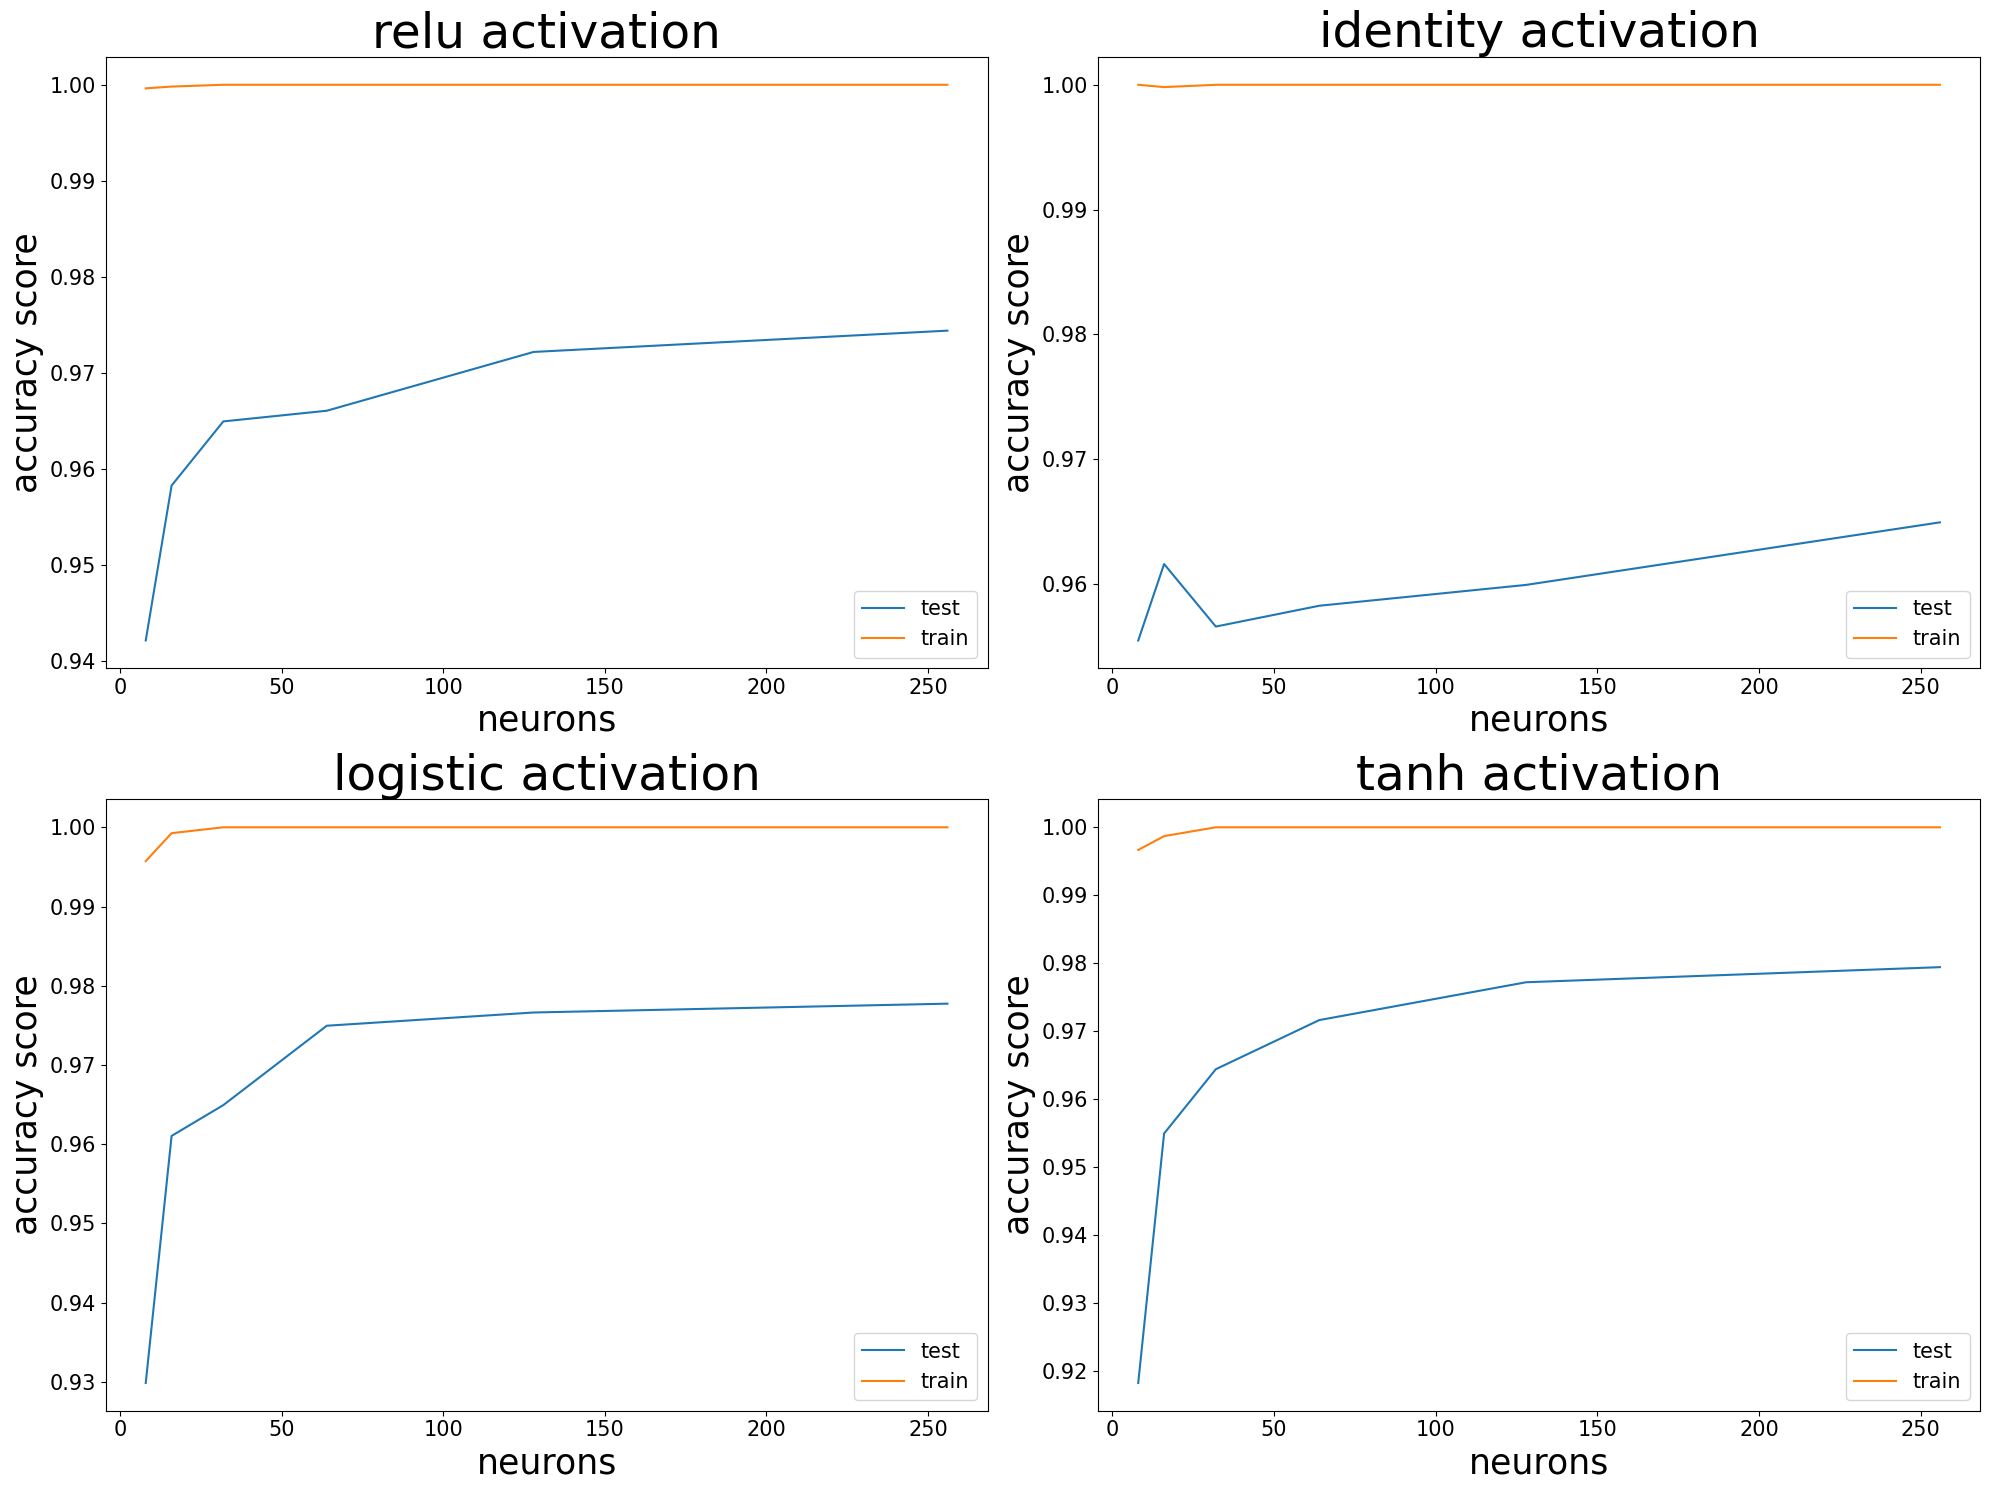

In [10]:
activations = ['relu', 'identity', 'logistic', 'tanh']
plt.figure(figsize=(20,15))
plot_num = list(range(1,5))

for act, num in zip(activations, plot_num):
    neurons = [8, 16, 32, 64, 128, 256]
    test_accuracy_scores = list()
    train_accuracy_scores = list()

    neurons = [8, 16, 32, 64, 128, 256]
    for i in neurons:
        mlp = MLPClassifier(hidden_layer_sizes=(i, ),
                            activation=act,
                            max_iter=1000)
        test_accuracy, train_accuracy = cross_validate(df=df,
                                                       target=target,
                                                       model=mlp)
        test_accuracy_scores.append(test_accuracy)
        train_accuracy_scores.append(train_accuracy)

    plt.subplot(2, 2, num)
    plt.plot(neurons, test_accuracy_scores)
    plt.plot(neurons, train_accuracy_scores)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(["test", "train"], fontsize=15)
    plt.xlabel("neurons", size=25)
    plt.ylabel("accuracy score", size=25)
    plt.title(f'{act} activation', size=35)

plt.tight_layout()
plt.show()

With cross validation, the average test accuracies move in the same direction and all flatten around a 98% accuracy.

### Neural Network With Two Hidden Layers

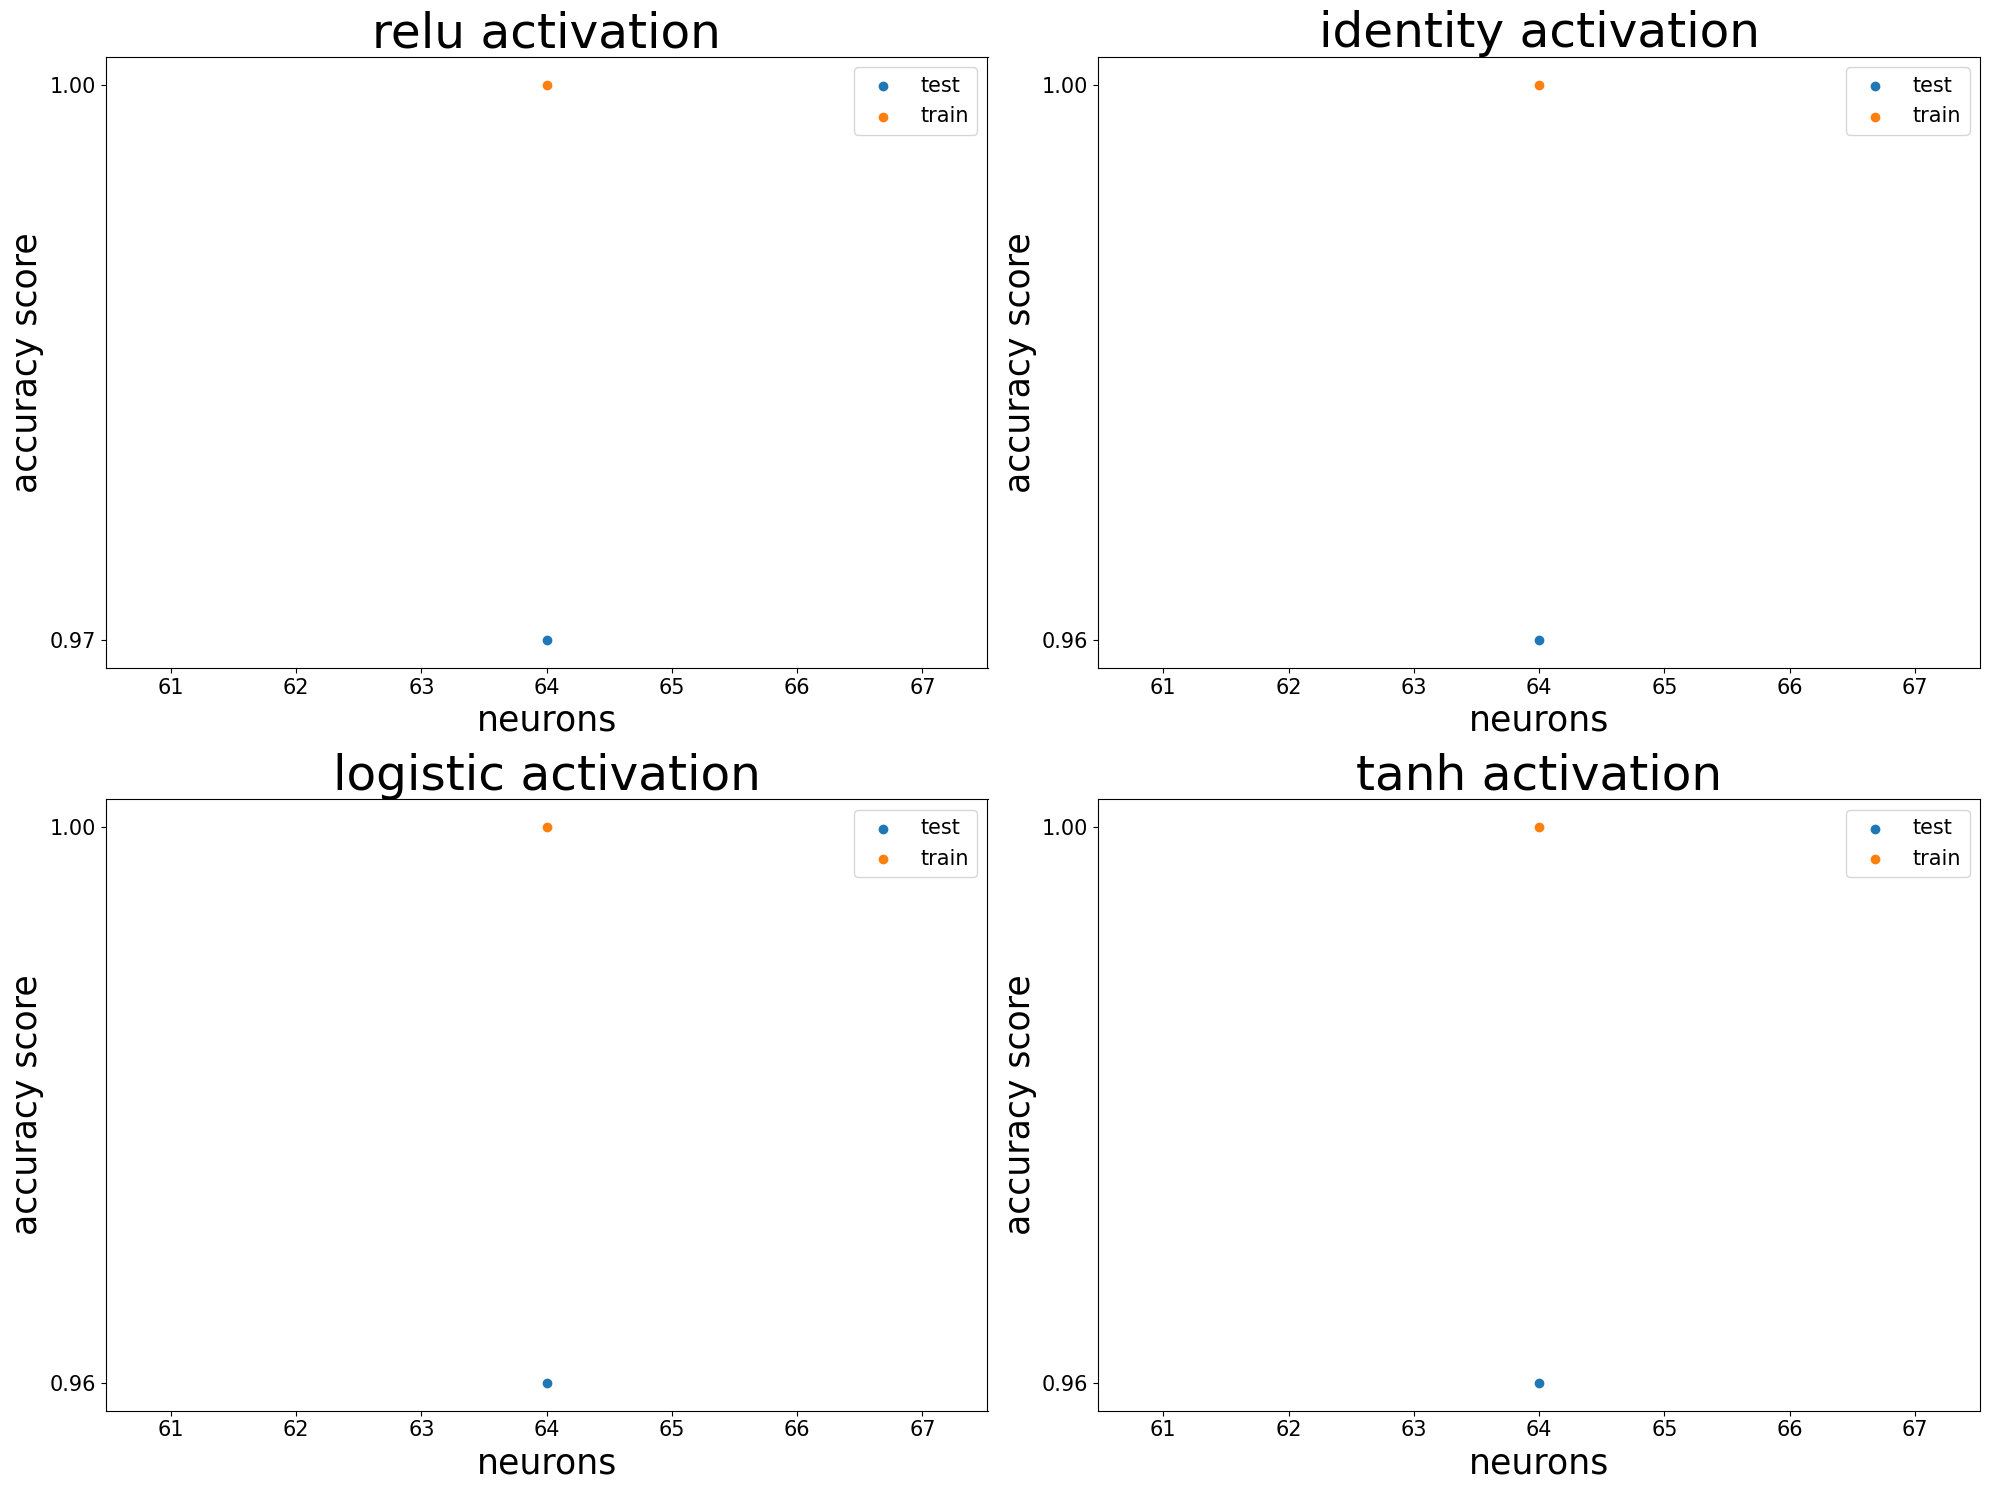

In [12]:
activations = ['relu', 'identity', 'logistic', 'tanh']
plt.figure(figsize=(20,15))
plot_num = list(range(1,5))


for act, num in zip(activations, plot_num):
    neurons = [64]
    nn_train_accuracies = list()
    nn_test_accuracies = list()

    for i in neurons:
        mlp = MLPClassifier(hidden_layer_sizes=(i, i),
                            activation=act,
                            max_iter=1000)
        mlp.fit(train_features, train_labels)
        nn_train_accuracy = mlp.score(train_features, train_labels)
        nn_train_accuracies.append(f'{nn_train_accuracy:.2f}')

        nn_predictions = mlp.predict(test_features)
        nn_test_accuracy = accuracy_score(test_labels,
                                          nn_predictions)
        nn_test_accuracies.append(f'{nn_test_accuracy:.2f}')

    plt.subplot(2, 2, num)
    plt.scatter(neurons, nn_test_accuracies)
    plt.scatter(neurons, nn_train_accuracies)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(["test", "train"], fontsize=15)
    plt.xlabel("neurons", size=25)
    plt.ylabel("accuracy score", size=25)
    plt.title(f'{act} activation', size=35)

plt.tight_layout()
plt.show()

Models with 2 hidden layers have a high test accuracy, across all activation parameters. There's no overfitting as the train and test sets are nearly identical. Accuracy for all activation hyperparameters are around 96% save for ReLU which is at 97%.

Neural Network With Three Hidden Layers

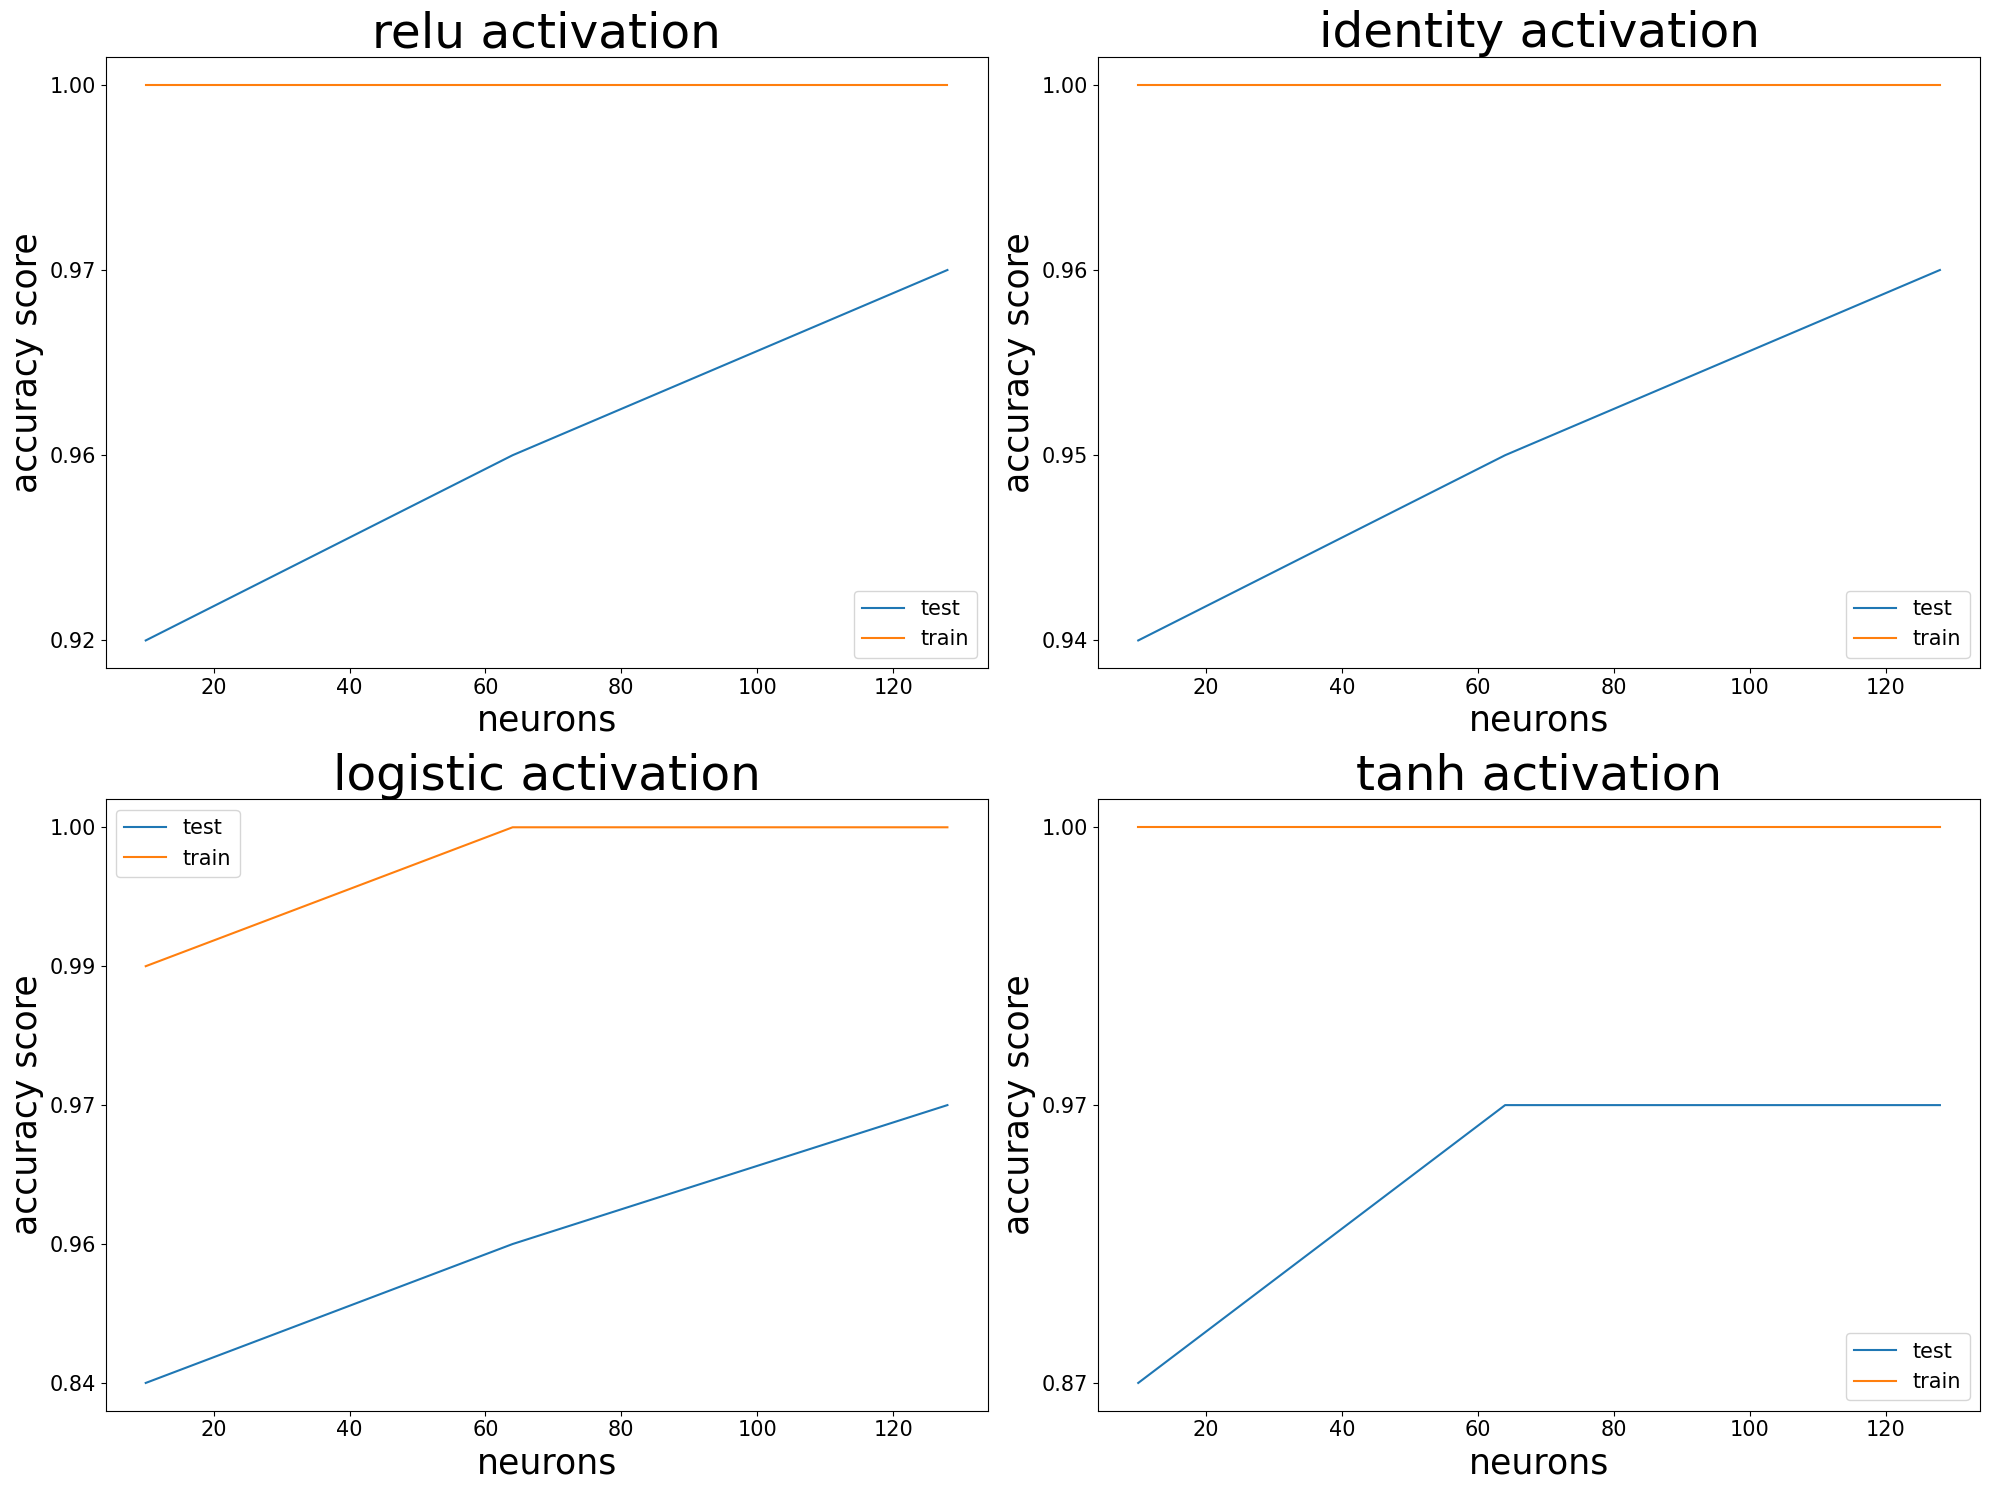

In [14]:
activations = ['relu', 'identity', 'logistic', 'tanh']
plt.figure(figsize=(20,15))
plot_num = list(range(1,5))


for act, num in zip(activations, plot_num):
    neurons = [10, 64, 128]
    nn_train_accuracies = list()
    nn_test_accuracies = list()

    for i in neurons:
        mlp = MLPClassifier(hidden_layer_sizes=(i, i, i),
                            activation=act,
                            max_iter=1000)
        mlp.fit(train_features, train_labels)
        nn_train_accuracy = mlp.score(train_features, train_labels)
        nn_train_accuracies.append(f'{nn_train_accuracy:.2f}')

        nn_predictions = mlp.predict(test_features)
        nn_test_accuracy = accuracy_score(test_labels,
                                          nn_predictions)
        nn_test_accuracies.append(f'{nn_test_accuracy:.2f}')

    plt.subplot(2, 2, num)
    plt.plot(neurons, nn_test_accuracies)
    plt.plot(neurons, nn_train_accuracies)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(["test", "train"], fontsize=15)
    plt.xlabel("neurons", size=25)
    plt.ylabel("accuracy score", size=25)
    plt.title(f'{act} activation', size=35)

plt.tight_layout()
plt.show()

All models performed well on both train and test sets. This implies that there was no overfitting, since models that overfit tend to perform well on the train set but poorly on the test set.

### Conclusion
All our tested neural network multi-layer perception classifier models perform well for the digit classification.

**Next Steps**
* Use the existing pipeline you've built to try other machine learning models:
    * Decision Tree Models
    * Random Forest Models
* Write up a summary of the effectiveness of the different models you tried, with data to back up your conclusions.
* Experiment with different activation functions to see if the accuracies improve.
* Research some techniques for visualizing weights in neural network models and add a visualization step to your pipeline.
    * Visualization of MLP Weights on MNIST